# ResNet on CIFAR10 using PyTorch Lightning

https://www.pytorchlightning.ai/

## Configuration

Imports

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms

import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning import loggers

Configuration

In [2]:
DATA_DIR = './data'
LOG_DIR = './logs'
MODEL_DIR = './models'

NUM_CLASSES = 10
NUM_WORKERS = 24
BATCH_SIZE = 32
EPOCHS = 50

## Data

In [3]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

In [4]:
class CIFAR10DataModule(pl.LightningDataModule):
    def __init__(self, train_transform, data_dir='./', batch_size=32, num_workers=8):
        super().__init__()
        self.train_transform = train_transform
        self.val_transform = transforms.ToTensor()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
    
    def prepare_data(self):
        datasets.CIFAR10(root=self.data_dir, train=True, download=True)
        datasets.CIFAR10(root=self.data_dir, train=False, download=True)
    
    def setup(self, stage=None):
        if stage == 'fit' or stage is None:
            self.train_dset = datasets.CIFAR10(root=self.data_dir, train=True,
                                               transform=self.train_transform)
            self.val_dset = datasets.CIFAR10(root=self.data_dir, train=False,
                                             transform=self.val_transform)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self.train_dset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, pin_memory=True)


    def val_dataloader(self):
        return torch.utils.data.DataLoader(self.val_dset, batch_size=self.batch_size,
                                           num_workers=self.num_workers, pin_memory=True)

In [5]:
dm = CIFAR10DataModule(train_transform, data_dir=DATA_DIR, batch_size=BATCH_SIZE,
                       num_workers=NUM_WORKERS)

In [6]:
dm.prepare_data()

Files already downloaded and verified
Files already downloaded and verified


In [7]:
dm.setup()

## Model

In [8]:
class ConvBlock(nn.Sequential):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, act=True):
        padding = (kernel_size - 1) // 2
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_channels)
        ]
        if act: layers.append(nn.ReLU(inplace=True))
        super().__init__(*layers)

In [9]:
class BasicResidual(nn.Sequential):
    def __init__(self, in_channels, out_channels):
        super().__init__(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels, act=False)
        )

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.shortcut = self.get_shortcut(in_channels, out_channels)
        self.residual = BasicResidual(in_channels, out_channels)
        self.act = nn.ReLU(inplace=True)
        self.gamma = nn.Parameter(torch.zeros(1))
    
    def forward(self, x):
        out = self.shortcut(x) + self.gamma * self.residual(x)
        return self.act(out)
    
    def get_shortcut(self, in_channels, out_channels):
        if in_channels != out_channels:
            shortcut = ConvBlock(in_channels, out_channels, 1, act=False)
        else:
            shortcut = nn.Identity()
        return shortcut

In [11]:
class ResidualStack(nn.Sequential):
    def __init__(self, in_channels, repetitions, strides):
        layers = []
        out_channels = in_channels
        for num_blocks, stride in zip(repetitions, strides):
            if stride > 1: layers.append(nn.MaxPool2d(stride))
            for _ in range(num_blocks):
                layers.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
            out_channels *= 2
        super().__init__(*layers)

In [12]:
class Stem(nn.Sequential):
    def __init__(self, in_channels, channel_list, stride):
        layers = []
        for out_channels in channel_list:
            layers.append(ConvBlock(in_channels, out_channels, stride))
            in_channels = out_channels
            stride = 1
        super().__init__(*layers)

In [13]:
class Head(nn.Sequential):
    def __init__(self, in_channels, classes, p_drop=0.):
        super().__init__(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(p_drop),
            nn.Linear(in_channels, classes)
        )

In [14]:
class ResNet(nn.Sequential):
    def __init__(self, classes, repetitions, strides=None, in_channels=3, head_p_drop=0.):
        if strides is None: strides = [2] * (len(repetitions) + 1)
        super().__init__(
            Stem(in_channels, [32, 32, 64], strides[0]),
            ResidualStack(64, repetitions, strides[1:]),
            Head(64 * 2**(len(repetitions) - 1), classes, head_p_drop)
        )

In [15]:
def init_linear(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.kaiming_normal_(m.weight)
        if m.bias is not None: nn.init.zeros_(m.bias)

In [16]:
model = ResNet(NUM_CLASSES, [2, 2, 2, 2], strides=[1, 1, 2, 2, 2], head_p_drop=0.3)

In [17]:
model.apply(init_linear);

## Task

In [18]:
class ClassificationTask(pl.LightningModule):
    def __init__(self, model, max_lr, epochs):
        super().__init__()
        self.save_hyperparameters('max_lr', 'epochs')
        self.model = model
        self.loss = nn.CrossEntropyLoss()
        self.train_acc = torchmetrics.Accuracy(compute_on_step=False)
        self.val_acc = torchmetrics.Accuracy(compute_on_step=False)
    
    def forward(self, x):
        return self.model(x)
    
    def _shared_step(self, batch, metric, prefix):
        x, y = batch
        logits = self.model(x)
        loss = self.loss(logits, y)
        metric(F.softmax(logits, dim=1), y)  # torchmetrics v. 0.3.2 is buggy !!!
        self.log(f'{prefix}_loss', loss, on_step=False, on_epoch=True)
        self.log(f'{prefix}_acc', metric, on_step=False, on_epoch=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, self.train_acc, 'train')
        
    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, self.val_acc, 'val')
        
    def configure_optimizers(self):
        optimizer = optim.AdamW(self.model.parameters(), weight_decay=1e-2)
        lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=self.hparams.max_lr,
                                                     steps_per_epoch=len(self.trainer.datamodule.train_dataloader()),
                                                     epochs=self.hparams.epochs)
        lr_dict = {'scheduler': lr_scheduler, 'interval': 'step'}
        return [optimizer], [lr_dict]

In [19]:
classifier = ClassificationTask(model, max_lr=1e-2, epochs=EPOCHS)

## Training

In [20]:
logger = loggers.CSVLogger(LOG_DIR)

In [21]:
trainer = pl.Trainer(gpus=1, max_epochs=EPOCHS, logger=logger, progress_bar_refresh_rate=10)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [22]:
lr_finder = trainer.tuner.lr_find(classifier, datamodule=dm, min_lr=1e-6, max_lr=1e-1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 11.2 M
1 | loss      | CrossEntropyLoss | 0     
2 | train_acc | Accuracy         | 0     
3 | val_acc   | Accuracy         | 0     
-----------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.702    Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /home/julius/cifar10/lr_find_temp_model.ckpt


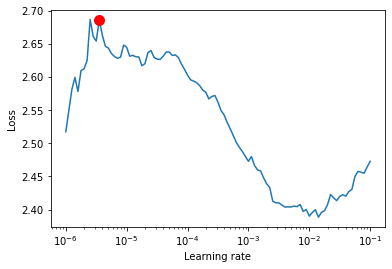

In [23]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [ ]:
trainer.fit(classifier, datamodule=dm)

In [25]:
trainer.save_checkpoint(os.path.join(MODEL_DIR, 'model.ckpt'))

In [27]:
df = pd.read_csv(os.path.join(LOG_DIR, "default", "version_0", "metrics.csv"))

In [28]:
df = df.groupby(df['epoch']).aggregate(max)

In [29]:
def plot_train_val(df, key):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(df.index, df['train_' + key], '.-', label='train')
    ax.plot(df.index, df['val_' + key], '.-', label='val')
    ax.set_xlabel('epoch')
    ax.set_ylabel(key)
    ax.legend()
    plt.show()

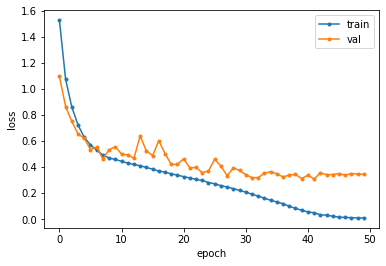

In [30]:
plot_train_val(df, 'loss')

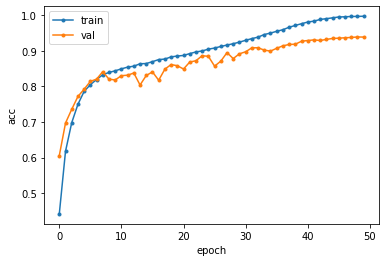

In [31]:
plot_train_val(df, 'acc')